### Create synthetic dataset

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n = 4000

# Define race categories
race_categories = [0, 1, 2, 3, 4]  # ['White', 'Black', 'Hispanic', 'Asian', 'Other']
race_labels = ['White', 'Black', 'Hispanic', 'Asian', 'Other']

# Define infection rates for each race
total_infection_rates = {
    0: 9.1,   # White
    1: 39.7,  # Black
    2: 16.9,  # Hispanic
    3: 4.4,   # Asian
    4: 58.2   # Other
}

# Calculate race probabilities based on infection rates
total_sum = sum(total_infection_rates.values())
race_probabilities = [rate / total_sum for rate in total_infection_rates.values()]

print("Race probabilities:")
print({race_label: prob for race_label, prob in zip(race_labels, race_probabilities)})

# Generate race data
race = np.random.choice(race_categories, size=n, p=race_probabilities)

# Simulate other variables
severity = np.random.normal(0, 1, size=n)  # Severity ~ N(0,1)
instrument = np.random.choice([0, 1], size=n, p=[0.5, 0.5])  # Instrument variable

# Define race bias weights for Treatment
race_bias = {0: 0, 1: -1, 2: -0.6, 3: 0.1, 4: -0.3}  # Bias weights for each race
race_bias_values = np.array([race_bias[r] for r in race])

# Generate Treatment using logistic regression
logit_treatment = race_bias_values + 0.5 * severity + 0.8 * instrument
treatment_prob = 1 / (1 + np.exp(-logit_treatment))  # Sigmoid function
treatment = np.random.binomial(1, treatment_prob)

# Generate potential outcomes Y0 and Y1
logit_y0 = -severity
logit_y1 = 1.5 - severity
y0 = 1 / (1 + np.exp(-logit_y0))  # Logistic function for Y0
y1 = 1 / (1 + np.exp(-logit_y1))  # Logistic function for Y1

# Observed outcome with random noise
outcome = np.where(treatment == 1, y1, y0)  # Select Y1 or Y0 based on Treatment
outcome += np.random.normal(0, 0.05, len(outcome))  # Add noise to the observed outcome

# Construct the DataFrame
data = pd.DataFrame({
    'Race': race,
    'Severity': severity,
    'Instrument': instrument,
    'Treatment': treatment,
    'Y0': y0,
    'Y1': y1,
    'Outcome': outcome
})

# Dummy columns for Race
data_one_hot = pd.get_dummies(data, columns=['Race'], prefix='Race')
dummy_columns = [col for col in data_one_hot.columns if col.startswith('Race_')]
data_one_hot[dummy_columns] = data_one_hot[dummy_columns].astype(int)
data = data_one_hot.copy()
data['Outcome_prob'] = data['Outcome']
data = data.dropna(subset=['Outcome_prob'])
data['Outcome_prob'] = np.clip(data['Outcome_prob'], 0, 1)
data['Outcome_binary'] = np.random.binomial(1, data['Outcome_prob'])

Race probabilities:
{'White': 0.07092751363990646, 'Black': 0.3094310210444271, 'Hispanic': 0.13172252533125484, 'Asian': 0.034294621979735, 'Other': 0.4536243180046765}


### Explore the dataset

In [6]:
data

,Severity,Instrument,Treatment,Y0,Y1,Outcome,Race_0,Race_1,Race_2,Race_3,Race_4,Outcome_prob,Outcome_binary
0,1.328641,0,0,0.209384,0.542735,0.281390,0,1,0,0,0,0.281390,0
1,0.313184,0,0,0.422338,0.766171,0.439959,0,0,0,0,1,0.439959,1
2,-0.606503,0,0,0.647143,0.891534,0.614092,0,0,0,0,1,0.614092,1
3,0.455904,1,0,0.387958,0.739640,0.427920,0,0,0,0,1,0.427920,1
4,-0.459090,0,0,0.612798,0.876434,0.641085,0,1,0,0,0,0.641085,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.660460,1,0,0.340636,0.698368,0.330581,0,0,1,0,0,0.330581,0
3996,-0.385493,0,0,0.595197,0.868241,0.615811,0,1,0,0,0,0.615811,1
3997,-2.071377,0,0,0.888090,0.972652,0.857285,0,0,1,0,0,0.857285,1
3998,1.167742,0,1,0.237263,0.582309,0.624785,0,0,0,1,0,0.624785,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Severity        4000 non-null   float64
 1   Instrument      4000 non-null   int32  
 2   Treatment       4000 non-null   int32  
 3   Y0              4000 non-null   float64
 4   Y1              4000 non-null   float64
 5   Outcome         4000 non-null   float64
 6   Race_0          4000 non-null   int32  
 7   Race_1          4000 non-null   int32  
 8   Race_2          4000 non-null   int32  
 9   Race_3          4000 non-null   int32  
 10  Race_4          4000 non-null   int32  
 11  Outcome_prob    4000 non-null   float64
 12  Outcome_binary  4000 non-null   int32  
dtypes: float64(5), int32(8)
memory usage: 281.4 KB


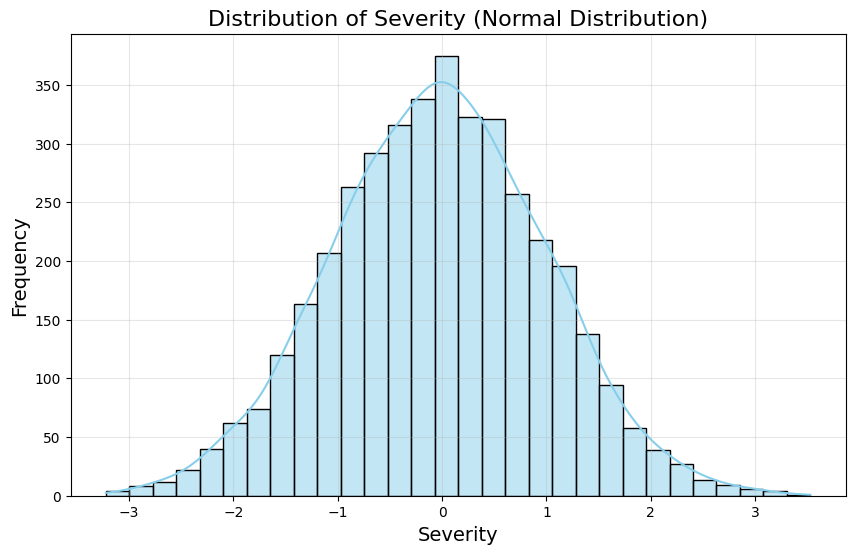

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of severity
plt.figure(figsize=(10, 6))
sns.histplot(severity, kde=True, bins=30, color='skyblue')  # Histogram with KDE
plt.title('Distribution of Severity (Normal Distribution)', fontsize=16)
plt.xlabel('Severity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

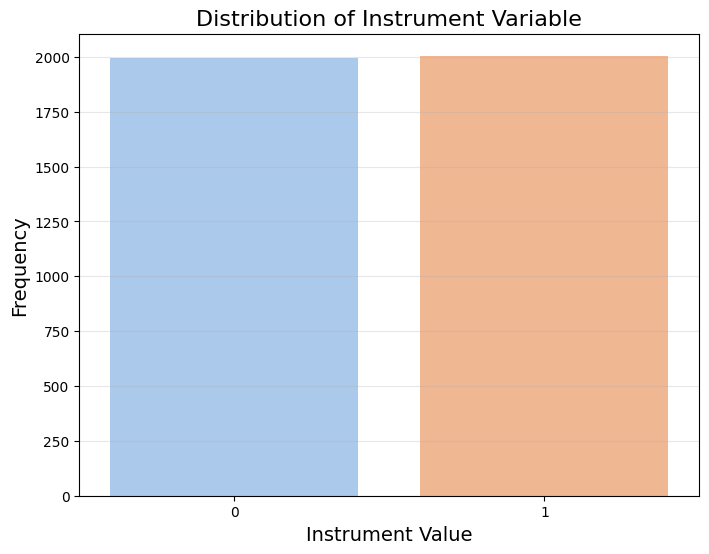

In [3]:
# Plot bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x=instrument, palette='pastel')
plt.title('Distribution of Instrument Variable', fontsize=16)
plt.xlabel('Instrument Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks([0, 1], labels=['0', '1'])
plt.grid(axis='y', alpha=0.3)
plt.show()

In [2]:
data.to_csv("dataset.csv")

In [8]:
data.describe()

,Severity,Instrument,Treatment,Y0,Y1,Outcome,Race_0,Race_1,Race_2,Race_3,Race_4,Outcome_prob,Outcome_binary
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.030842,0.501250,0.469250,0.506363,0.782030,0.644410,0.076250,0.30775,0.127500,0.034000,0.454500,0.644030,0.654750
std,1.015619,0.500061,0.499116,0.210809,0.155971,0.217768,0.265431,0.46162,0.333574,0.181252,0.497988,0.217081,0.475509
min,-3.221016,0.000000,0.000000,0.028497,0.116186,-0.016966,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.724678,0.000000,0.000000,0.339128,0.696951,0.493739,0.000000,0.00000,0.000000,0.000000,0.000000,0.493739,0.000000
50%,-0.025877,1.000000,0.000000,0.506469,0.821402,0.679029,0.000000,0.00000,0.000000,0.000000,0.000000,0.679029,1.000000
75%,0.667181,1.000000,1.000000,0.673636,0.902444,0.817045,0.000000,1.00000,0.000000,0.000000,1.000000,0.817045,1.000000
max,3.529055,1.000000,1.000000,0.961618,0.991172,1.134348,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


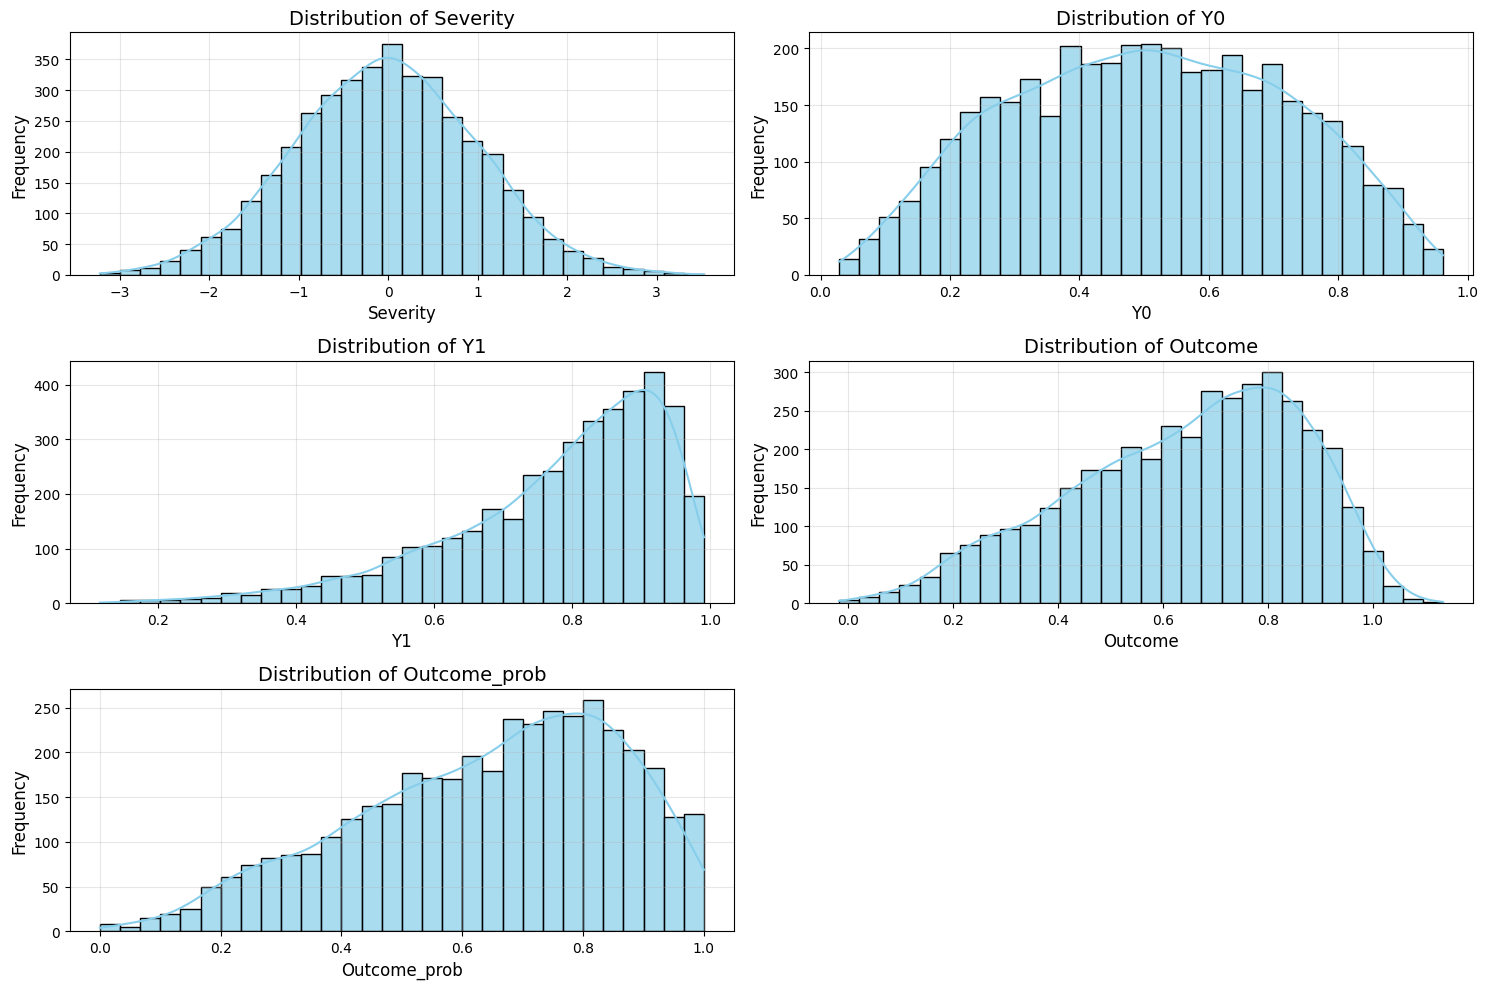

In [9]:
# Continuous variables
continuous_columns = ['Severity', 'Y0', 'Y1', 'Outcome', 'Outcome_prob']

# Plot distributions for continuous variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[col], kde=True, bins=30, color='skyblue', alpha=0.7)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
from dowhy import CausalModel

# Define Causal Graph
graph = """
digraph {
    Treatment -> Outcome_binary;
    Race -> Treatment;
    Race -> Outcome_binary;
    Severity -> Treatment;
    Severity -> Outcome_binary;
    Instrument -> Treatment;
    U [unobserved];
    U -> Treatment;
    U -> Outcome_binary;
}
"""

# Define Causal Model
model = CausalModel(
    data=data,
    treatment='Treatment',
    outcome='Outcome_binary',
    common_causes=['Severity'] + dummy_columns,
    instruments=['Instrument'],
    graph=graph
)

# Identify Causal Effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("="*50)
print("Identified Estimand (do-calculus derivative result):")
print("="*50)
print(identified_estimand)

# Tool Variable Estimation
iv_estimate = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable",
    method_params={'iv_instrument_name': 'Instrument'}
)
print("\n Tool Variable Estimation (IV Estimation):")
print(f"LATE: {iv_estimate.value:.4f}")

# BootstrapRefuter Estimation
refute_iv = model.refute_estimate(
    identified_estimand,
    iv_estimate,
    method_name="bootstrap_refuter",
    num_simulations=100
)
print("\nBootstrap Refuter for IV Estimation:")
print(refute_iv)

Identified Estimand (do-calculus derivative result):
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                          -1⎤
 ⎢      d                       ⎛      d                   ⎞  ⎥
E⎢─────────────(Outcome_binary)⋅⎜─────────────([Treatment])⎟  ⎥
 ⎣d[Instrument]                 ⎝d[Instrument]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Outcome_binary then ¬(U →→{Instrument})
Estimand assumption 2, Exclusion: If we remove {Instrument}→{Treatment}, then ¬({Instrument}→Outcome_binary)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


 Tool Variable Estimation (IV Estimation):
LATE: 0.2065

Bootstrap Refuter for IV Estimation:
Refute: Bootstrap Sample Dataset
Estimated effect:0.20645679604112785
New effect:0.2107202918597138
p value:0.94



$$
\text{Estimand} = E\left[\frac{\partial \text{Outcome\_binary}}{\partial \text{Instrument}} \cdot \frac{\partial \text{Treatment}}{\partial \text{Instrument}}^{-1}\right]
$$

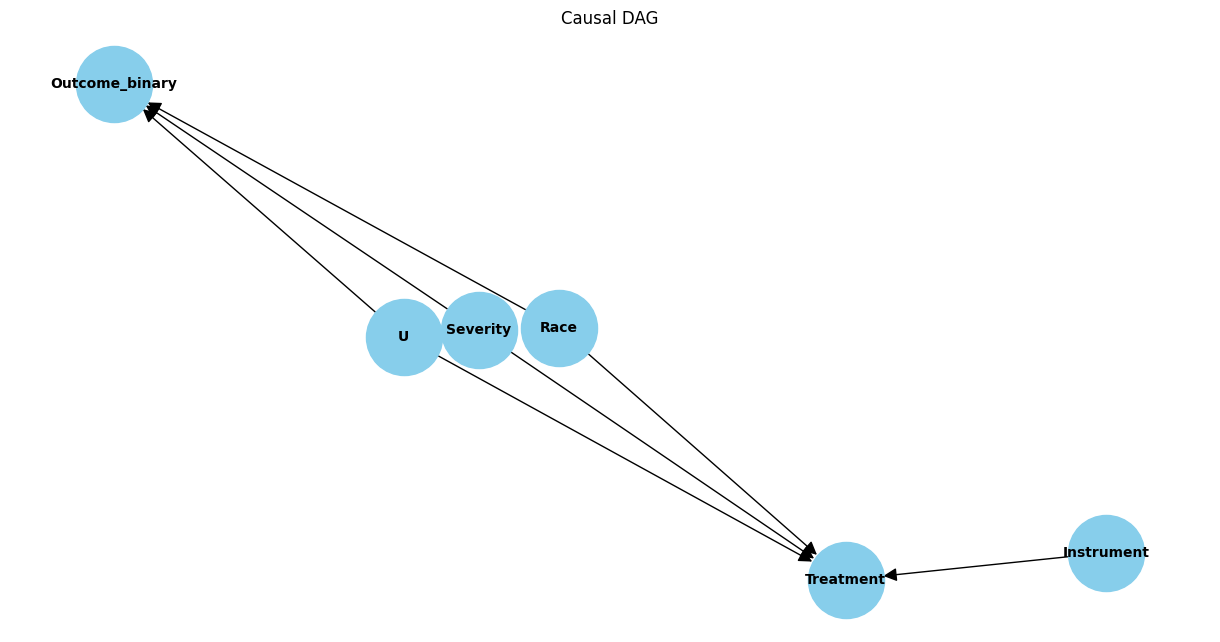

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Introduce unobserved confounder U
data['U'] = np.random.normal(0, 1, size=n)

# Generate logit for Treatment
logit_treatment = (
    0.5 * data['Severity'] +          # Effect of Severity
    0.8 * data['Instrument'] +        # Effect of Instrument
    0.3 * data['U'] +                 # Effect of unobserved confounder U
    np.random.normal(0, 1, size=n)    # Random noise
)
data['Treatment'] = np.random.binomial(1, 1 / (1 + np.exp(-logit_treatment)))  # Generate binary Treatment

# Generate logit for potential outcomes Y0 and Y1
logit_y0 = -data['Severity'] + 0.2 * data['U']  # Effect of U on Y0
logit_y1 = 1.5 - data['Severity'] + 0.5 * data['U']  # Effect of U on Y1
data['Y0'] = 1 / (1 + np.exp(-logit_y0))  # Convert logit to probability for Y0
data['Y1'] = 1 / (1 + np.exp(-logit_y1))  # Convert logit to probability for Y1

# Generate observed outcome based on Treatment
data['Outcome_binary'] = np.where(data['Treatment'] == 1, data['Y1'], data['Y0'])

# Create causal DAG
G = nx.DiGraph()
G.add_edges_from([
    ('Race', 'Treatment'),             # Race affects Treatment
    ('Race', 'Outcome_binary'),        # Race affects Outcome_binary
    ('Severity', 'Treatment'),         # Severity affects Treatment
    ('Severity', 'Outcome_binary'),    # Severity affects Outcome_binary
    ('Instrument', 'Treatment'),       # Instrument affects Treatment
    ('U', 'Treatment'),                # U (unobserved confounder) affects Treatment
    ('U', 'Outcome_binary')            # U (unobserved confounder) affects Outcome_binary
])

# Visualize causal DAG
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)  # Use spring layout for DAG
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, 
        font_size=10, font_weight='bold', arrowsize=20)
plt.title("Causal DAG")
plt.show()

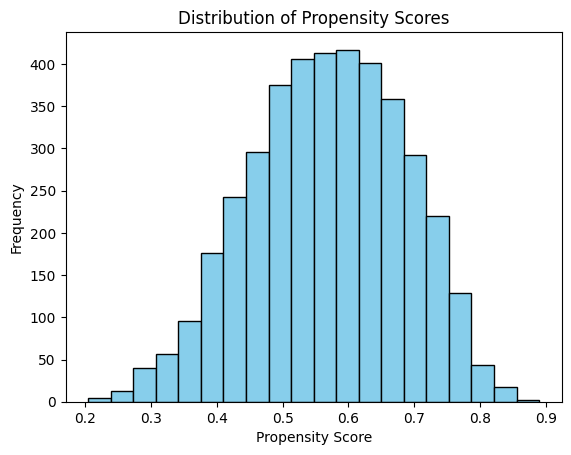

In [12]:
from sklearn.linear_model import LogisticRegression
# Propensity score modeling
X = data[dummy_columns + ['Severity', 'Instrument']]
y = data['Treatment']  # Treatment indicator

# Logistic regression model for propensity score
propensity_model = LogisticRegression()
propensity_model.fit(X, y)  # Fit the model 

# Predicted probabilities for Treatment=1
data['Propensity_Score'] = propensity_model.predict_proba(X)[:, 1]

# Check the distribution of propensity scores
plt.hist(data['Propensity_Score'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Propensity Scores")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.show()

In [8]:
# ATE (Average Treatment Effect)
ate = np.mean(data['Y1'] - data['Y0'])
print(f"ATE (Average Treatment Effect): {ate}")

ATE (Average Treatment Effect): 0.26699520890382833



CATE by Race:
White       0.259888
Black       0.269050
Hispanic    0.266741
Asian       0.273326
Other       0.266394
dtype: float64


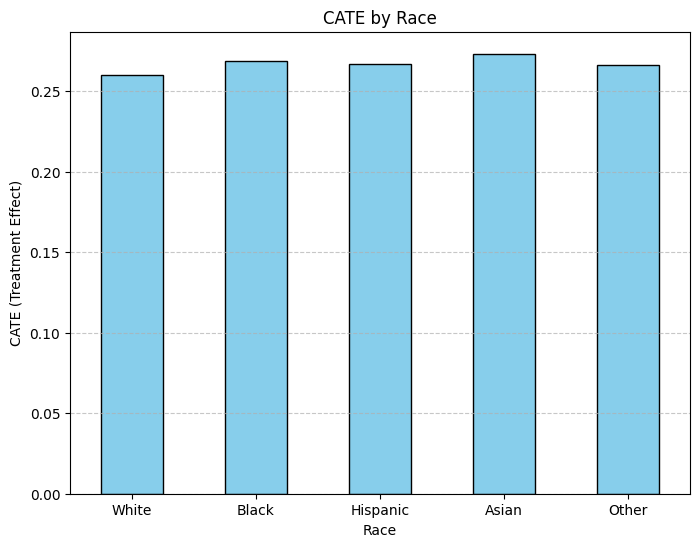

In [9]:
race_columns = ['Race_0', 'Race_1', 'Race_2', 'Race_3', 'Race_4']

cate = {}
for i, race_col in enumerate(race_columns):
    subset = data[data[race_col] == 1]
    cate[race_labels[i]] = np.mean(subset['Y1'] - subset['Y0'])

# Convert into Pandas Series
cate_series = pd.Series(cate)

# CATE Result
print("\nCATE by Race:")
print(cate_series)

# Visualize CATE
plt.figure(figsize=(8, 6))
cate_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("CATE by Race")
plt.xlabel("Race")
plt.ylabel("CATE (Treatment Effect)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# Print model coefficients (weights)
print("Model Coefficients (Weights):")
coefficients = pd.Series(propensity_model.coef_[0], index=X.columns)
print(coefficients)

# Print model intercept
print("\nModel Intercept:")
print(propensity_model.intercept_)

# Print model hyperparameters
print("\nModel Hyperparameters:")
print(propensity_model.get_params())

Model Coefficients (Weights):
Race_0       -0.216998
Race_1        0.049854
Race_2        0.101691
Race_3        0.070871
Race_4        0.002650
Severity      0.403906
Instrument    0.553076
dtype: float64

Model Intercept:
[0.00960998]

Model Hyperparameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [19]:
from sklearn.linear_model import LogisticRegression

race_columns = ['Race_0', 'Race_1', 'Race_2', 'Race_3', 'Race_4']

def add_race_category(data, race_columns, race_labels):
    for i, race_col in enumerate(race_columns):
        data.loc[data[race_col] == 1, 'Race_Category'] = race_labels[i]
    return data

data = add_race_category(data, race_columns, race_labels)

# Check if the Propensity_Score column was added successfully
print(data[['Race_Category', 'Propensity_Score', 'Treatment']].head())

# IPTW weight
data['IPTW_Weight'] = np.where(data['Treatment'] == 1, 
                               1 / data['Propensity_Score'], 
                               1 / (1 - data['Propensity_Score']))

# Weighted ATE (IPTW)
weighted_ate = np.mean(data['IPTW_Weight'] * (data['Y1'] - data['Y0']))
print(f"Weighted  ATE (IPTW): {weighted_ate}")

weighted_ate_by_race = data.groupby('Race_Category').apply(
    lambda df: np.mean(df['IPTW_Weight'] * (df['Y1'] - df['Y0']))
)
print("\nWeighted ATE (IPTW) by Race:")
print(weighted_ate_by_race)

  Race_Category  Propensity_Score  Treatment
0         Black          0.644766          0
1         Other          0.534634          1
2         Other          0.442083          0
3         Other          0.679065          0
4         Black          0.468550          0
Weighted  ATE (IPTW): 0.5336339819418477

Weighted ATE (IPTW) by Race:
Race_Category
Asian       0.536232
Black       0.535561
Hispanic    0.536300
Other       0.535181
White       0.511020
dtype: float64


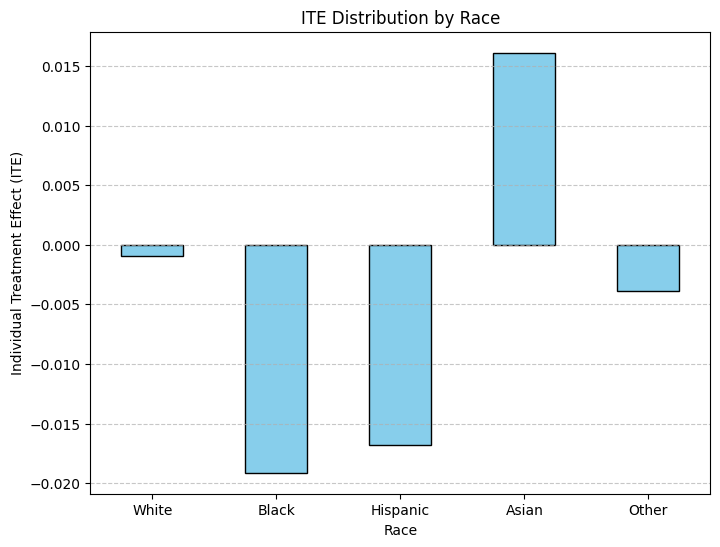

P(Y|do(T=1)): 0.6421459888544151
P(Y|T=1): 0.6173435219890933
Comparison: P(Y|do(T=1)) vs P(Y|T=1)


In [20]:
from sklearn.ensemble import RandomForestRegressor

# Fit two separate models: one for Treatment=0 and one for Treatment=1
model_t0 = RandomForestRegressor()
model_t1 = RandomForestRegressor()

# Train the models using all race dummy columns
model_t0.fit(data.loc[data['Treatment'] == 0, race_columns + ['Severity', 'Instrument']], 
             data.loc[data['Treatment'] == 0, 'Outcome'])
model_t1.fit(data.loc[data['Treatment'] == 1, race_columns + ['Severity', 'Instrument']], 
             data.loc[data['Treatment'] == 1, 'Outcome'])

# Predict counterfactual outcomes
data['Outcome_T0'] = model_t0.predict(data[race_columns + ['Severity', 'Instrument']])
data['Outcome_T1'] = model_t1.predict(data[race_columns + ['Severity', 'Instrument']])

# Calculate ITE
data['ITE'] = data['Outcome_T1'] - data['Outcome_T0']

# Visualize ITE distribution grouped by Race
plt.figure(figsize=(8, 6))
ite_by_race = []
for i, race_col in enumerate(race_columns):
    subset = data[data[race_col] == 1]
    ite_by_race.append(np.mean(subset['ITE']))

ite_series = pd.Series(ite_by_race, index=race_labels)
ite_series.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("ITE Distribution by Race")
plt.xlabel("Race")
plt.ylabel("Individual Treatment Effect (ITE)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Group Severity into bins for conditional probability estimation
data['Severity_Bin'] = pd.qcut(data['Severity'], q=10, labels=False)

# Calculate P(Y|do(T=1)) using do-calculus adjustment formula
do_treatment_estimates = data.groupby('Severity_Bin').apply(
    lambda df: np.mean(df.loc[df['Treatment'] == 1, 'Outcome']) * len(df) / len(data)
)

# Final P(Y|do(T=1))
p_y_do_t1 = do_treatment_estimates.sum()
print(f"P(Y|do(T=1)): {p_y_do_t1}")

# Compare P(Y|T=1) vs P(Y|do(T=1))
p_y_t1 = np.mean(data.loc[data['Treatment'] == 1, 'Outcome'])
print(f"P(Y|T=1): {p_y_t1}")
print(f"Comparison: P(Y|do(T=1)) vs P(Y|T=1)")

In [22]:
# Print ITE distribution by race
print("\nITE Distribution by Race:")
print(ite_series)

# Print P(Y|do(T=1))
print("\nP(Y|do(T=1)):")
print(f"P(Y|do(T=1)): {p_y_do_t1:.4f}")

# Print P(Y|T=1)
print("\nP(Y|T=1):")
print(f"P(Y|T=1): {p_y_t1:.4f}")


ITE Distribution by Race:
White      -0.000947
Black      -0.019127
Hispanic   -0.016801
Asian       0.016113
Other      -0.003900
dtype: float64

P(Y|do(T=1)):
P(Y|do(T=1)): 0.6421

P(Y|T=1):
P(Y|T=1): 0.6173


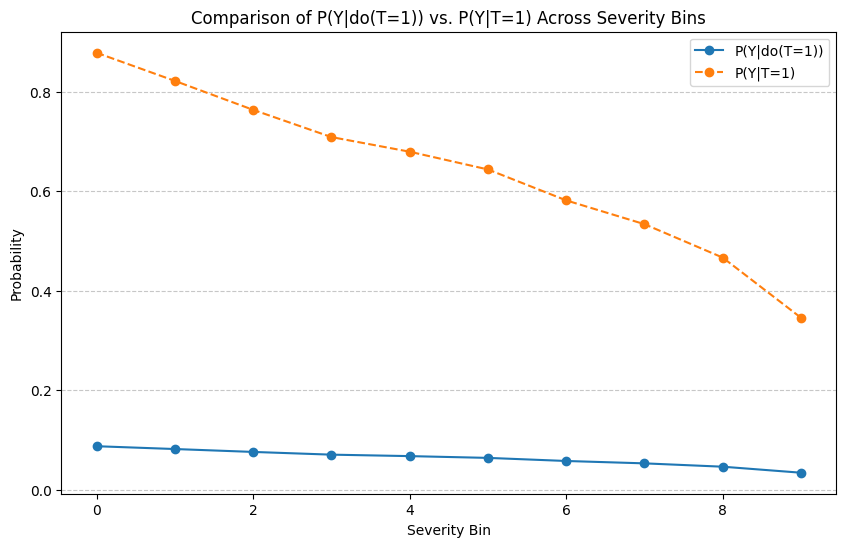

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data['Severity_Bin'] = pd.qcut(data['Severity'], q=10, labels=False)  # Split Severity into 10 Bins

do_treatment_estimates = data.groupby('Severity_Bin').apply(
    lambda df: np.mean(df.loc[df['Treatment'] == 1, 'Outcome']) * len(df) / len(data)
)

observed_treatment_estimates = data.groupby('Severity_Bin').apply(
    lambda df: np.mean(df.loc[df['Treatment'] == 1, 'Outcome'])
)

plt.figure(figsize=(10, 6))
plt.plot(do_treatment_estimates.index, do_treatment_estimates, label="P(Y|do(T=1))", marker='o', linestyle='-')
plt.plot(observed_treatment_estimates.index, observed_treatment_estimates, label="P(Y|T=1)", marker='o', linestyle='--')
plt.title("Comparison of P(Y|do(T=1)) vs. P(Y|T=1) Across Severity Bins")
plt.xlabel("Severity Bin")
plt.ylabel("Probability")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [31]:
# Initialize a list to store individual-level deviations
import seaborn as sns

race_category_names = race_labels  
X_columns = race_columns + ['Severity', 'Instrument']

individual_deviations = []
for i, row in data.iterrows():
    original_features = row[X_columns].values.reshape(1, -1)
    original_pred = propensity_model.predict_proba(original_features)[0, 1]
    
    for flipped_race in race_categories:
        flipped_features = row[X_columns].copy()
        flipped_features[race_columns] = 0
        flipped_features[f'Race_{flipped_race}'] = 1
        
        flipped_pred = propensity_model.predict_proba(flipped_features.values.reshape(1, -1))[0, 1]
        deviation = abs(original_pred - flipped_pred)
        individual_deviations.append({
            'Original_Race': row['Race_Category'],
            'Flipped_Race': race_category_names[flipped_race],
            'Deviation': deviation
        })

# Convert to DataFrame
individual_deviations_df = pd.DataFrame(individual_deviations)

# Aggregate deviations by Original_Race and Flipped_Race
fairness_deviation_matrix = individual_deviations_df.groupby(['Original_Race', 'Flipped_Race'])['Deviation'].mean().unstack()

# Map race categories to names
fairness_deviation_matrix.index = race_category_names
fairness_deviation_matrix.columns = race_category_names

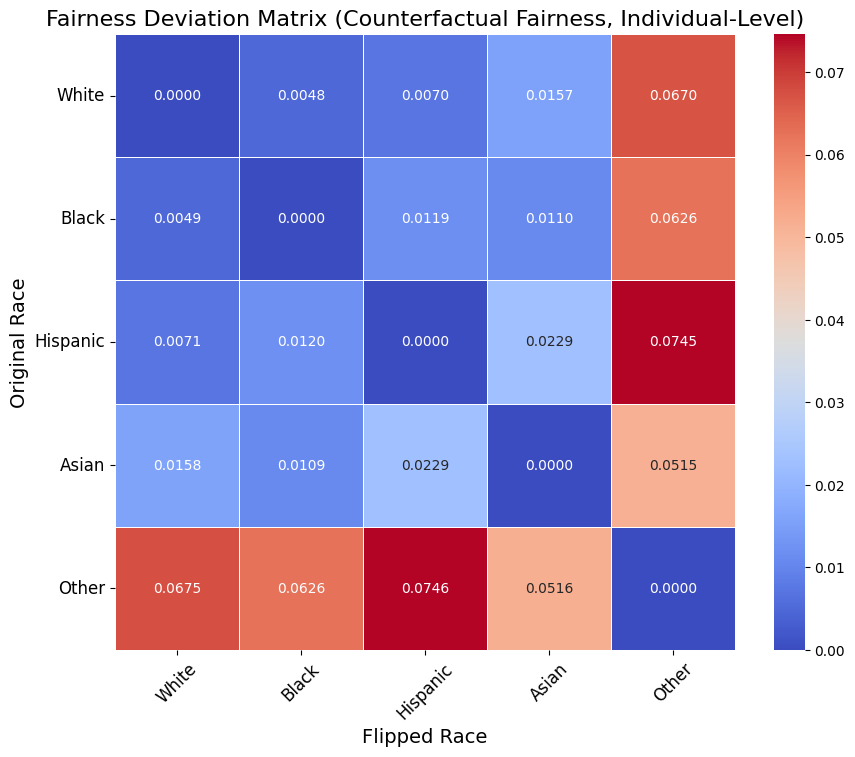

In [30]:
# Plot the fairness deviation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(fairness_deviation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title("Fairness Deviation Matrix (Counterfactual Fairness, Individual-Level)", fontsize=16)
plt.xlabel("Flipped Race", fontsize=14)
plt.ylabel("Original Race", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

In [14]:
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.calibration import calibration_curve

group_fairness_metrics = {}

for i, race_col in enumerate(race_columns):
    race_data = data[data[race_col] == 1]
    
    # Precision
    precision = precision_score(race_data['Treatment'], race_data['Propensity_Score'] > 0.5)
    
    # TPR and FPR
    tn, fp, fn, tp = confusion_matrix(race_data['Treatment'], race_data['Propensity_Score'] > 0.5).ravel()
    tpr = tp / (tp + fn)  # True Positive Rate
    fpr = fp / (fp + tn)  # False Positive Rate
    
    # Calibration
    prob_true, prob_pred = calibration_curve(race_data['Treatment'], race_data['Propensity_Score'], n_bins=10)
    calibration_error = np.mean(np.abs(prob_true - prob_pred))  # Mean absolute error

    # Store metrics
    group_fairness_metrics[race_labels[i]] = {
        'Precision': precision,
        'TPR': tpr,
        'FPR': fpr,
        'Calibration Error': calibration_error
    }

print("\nGroup Fairness Metrics:")
for race, metrics in group_fairness_metrics.items():
    print(f"{race}: {metrics}")


Group Fairness Metrics:
White: {'Precision': 0.6071428571428571, 'TPR': 0.7168674698795181, 'FPR': 0.5539568345323741, 'Calibration Error': 0.1389308127292164}
Black: {'Precision': 0.6284023668639053, 'TPR': 0.7662337662337663, 'FPR': 0.5836431226765799, 'Calibration Error': 0.05401205339243752}
Hispanic: {'Precision': 0.6256544502617801, 'TPR': 0.802013422818792, 'FPR': 0.6745283018867925, 'Calibration Error': 0.09639939959051744}
Asian: {'Precision': 0.6785714285714286, 'TPR': 0.9047619047619048, 'FPR': 0.6923076923076923, 'Calibration Error': 0.14358929319151661}
Other: {'Precision': 0.6330140014738393, 'TPR': 0.8165399239543726, 'FPR': 0.6501305483028721, 'Calibration Error': 0.05516299223619625}


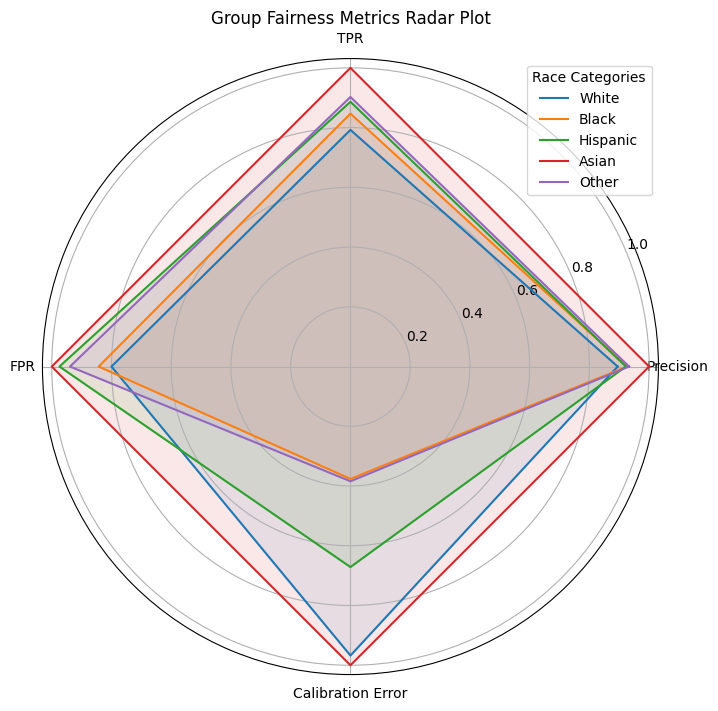

In [15]:
import matplotlib.pyplot as plt
from math import pi

race_category_names = ['White', 'Black', 'Hispanic', 'Asian', 'Other']

# Prepare data for radar plot
metrics = ['Precision', 'TPR', 'FPR', 'Calibration Error']
num_metrics = len(metrics)

# Normalize metrics for radar plot
normalized_metrics = {}
for race, values in group_fairness_metrics.items():
    normalized_metrics[race] = [values[metric] / max(values[metric] for values in group_fairness_metrics.values()) for metric in metrics]

# Radar plot
angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
angles += angles[:1]  # Close the plot

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for i, (race, values) in enumerate(normalized_metrics.items()):
    values += values[:1]  # Close the plot
    ax.plot(angles, values, label=race_category_names[i])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Group Fairness Metrics Radar Plot")
plt.legend(title="Race Categories")
plt.show()

In [32]:
from sklearn.ensemble import RandomForestRegressor

outcome_model = RandomForestRegressor()
outcome_model.fit(data[race_columns + ['Severity', 'Instrument', 'Treatment']], data['Outcome'])
data['Predicted_Outcome'] = outcome_model.predict(data[race_columns + ['Severity', 'Instrument', 'Treatment']])
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(data['Outcome'], data['Predicted_Outcome'])
r2 = r2_score(data['Outcome'], data['Predicted_Outcome'])

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 0.0492
R-squared (R2): 0.9205


In [33]:
outcome_deviations = []

for i, row in data.iterrows():
    original_race = [col for col in race_columns if row[col] == 1][0]
    original_features = row[race_columns + ['Severity', 'Instrument', 'Treatment']].copy()
    original_prediction = outcome_model.predict([original_features])[0]
    
    for flipped_race in race_columns:
        flipped_features = row[race_columns + ['Severity', 'Instrument', 'Treatment']].copy()
        flipped_features[race_columns] = 0
        flipped_features[flipped_race] = 1
        flipped_prediction = outcome_model.predict([flipped_features])[0]
        
        deviation = abs(original_prediction - flipped_prediction)
        outcome_deviations.append({
            'Original_Race': original_race,
            'Flipped_Race': flipped_race,
            'Deviation': deviation
        })

outcome_deviations_df = pd.DataFrame(outcome_deviations)
outcome_fairness_matrix = outcome_deviations_df.groupby(['Original_Race', 'Flipped_Race'])['Deviation'].mean().unstack()
outcome_fairness_matrix.index = race_category_names
outcome_fairness_matrix.columns = race_category_names
print("Outcome-Based Fairness Matrix:")
print(outcome_fairness_matrix)

Outcome-Based Fairness Matrix:
             White     Black  Hispanic     Asian     Other
White     0.000000  0.091678  0.073896  0.056694  0.069454
Black     0.083629  0.000000  0.077540  0.085989  0.088192
Hispanic  0.073166  0.084192  0.000000  0.068918  0.076065
Asian     0.062327  0.095879  0.079501  0.000000  0.070650
Other     0.060887  0.090163  0.069431  0.057562  0.000000


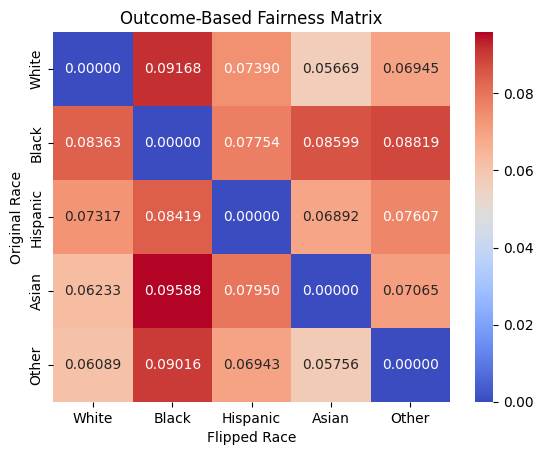

In [34]:
sns.heatmap(outcome_fairness_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title("Outcome-Based Fairness Matrix")
plt.xlabel("Flipped Race")
plt.ylabel("Original Race")
plt.show()

In [35]:
from sklearn.metrics import mean_absolute_error

group_metrics = {}

for i, race_col in enumerate(race_columns):
    race_data = data[data[race_col] == 1]
    mae = mean_absolute_error(race_data['Outcome'], race_data['Outcome_T1'])
    group_metrics[race_labels[i]] = {'MAE': mae}

print("Outcome Model Group Fairness Metrics:")
for race, metrics in group_metrics.items():
    print(f"{race}: {metrics}")

Outcome Model Group Fairness Metrics:
White: {'MAE': 0.0922579263773284}
Black: {'MAE': 0.08343724310300792}
Hispanic: {'MAE': 0.0873918660894247}
Asian: {'MAE': 0.07728018015906003}
Other: {'MAE': 0.0846520050169009}



Test Set MAE: 0.0134


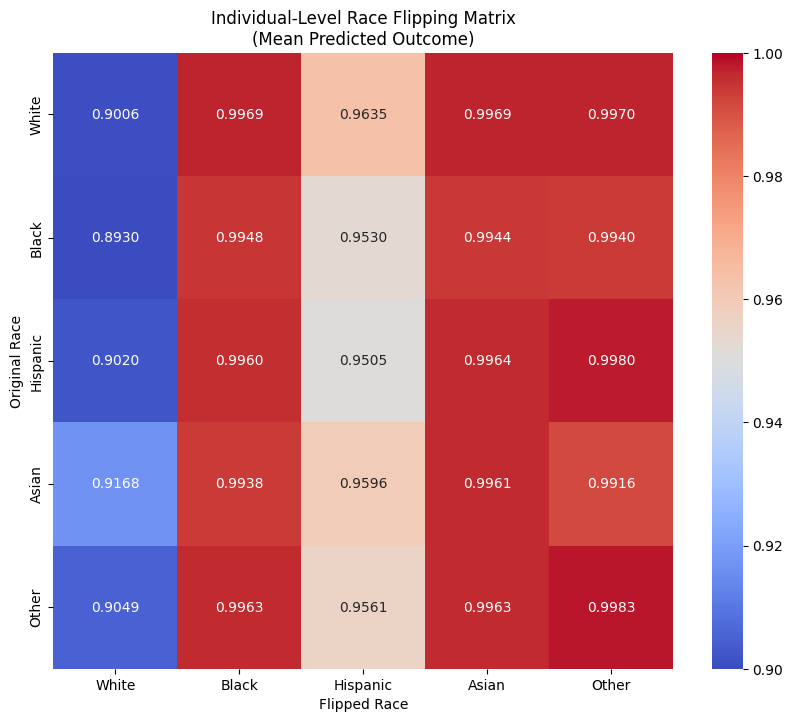


Top 5 Features:
Race_Severity     0.755234
Severity          0.163637
Race_Treatment    0.037427
Instrument        0.017308
Treatment         0.010010
dtype: float64

Fairness Metrics by Race:
White:
  MAE: 0.0041
  Mean Prediction: 0.9006
  Mean Actual: 0.9013
  Disparity: 0.07%
Black:
  MAE: 0.0250
  Mean Prediction: 0.9948
  Mean Actual: 0.9934
  Disparity: 0.14%
Hispanic:
  MAE: 0.0106
  Mean Prediction: 0.9505
  Mean Actual: 0.9489
  Disparity: 0.17%
Asian:
  MAE: 0.0001
  Mean Prediction: 0.9961
  Mean Actual: 0.9962
  Disparity: 0.01%
Other:
  MAE: 0.0286
  Mean Prediction: 0.9983
  Mean Actual: 1.0014
  Disparity: 0.31%


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

n = len(data)
logit_outcome = (
    0.5 * data['Severity'] + 
    0.8 * data['Instrument'] - 
    0.3 * data['Treatment'] + 
    5.0 * data['Race_0'] + 5.5 * data['Race_1'] + 4.5 * data['Race_2'] + 6.0 * data['Race_3'] + 6.5 * data['Race_4'] +
    3.0 * data['Race_0'] * data['Severity'] + 
    2.5 * data['Race_1'] * data['Instrument'] - 
    2.0 * data['Race_2'] * data['Treatment']
)

data['Outcome'] = 1 / (1 + np.exp(-logit_outcome))
data['Outcome'] += np.random.normal(0, 0.05, n)  # Add Noise

data['Race_Severity'] = data['Severity'] * data['Race_0']
data['Race_Instrument'] = data['Instrument'] * data['Race_1']
data['Race_Treatment'] = data['Treatment'] * data['Race_2']

feature_columns = race_columns + ['Severity', 'Instrument', 'Treatment', 
                                  'Race_Severity', 'Race_Instrument', 'Race_Treatment']

groups = [data[data[race_col] == 1] for race_col in race_columns]
max_size = max([len(group) for group in groups])
balanced_groups = [resample(group, replace=True, n_samples=max_size, random_state=42) 
                  for group in groups]
data_balanced = pd.concat(balanced_groups)

train_data, test_data = train_test_split(data_balanced, test_size=0.3, random_state=42)

def compute_individual_flipping_matrix(data, race_columns, outcome_model, feature_columns):
    n_races = len(race_columns)
    flipping_matrix = np.zeros((n_races, n_races))
    
    for orig_idx, orig_col in enumerate(race_columns):
        orig_data = data[data[orig_col] == 1].copy()
        
        for flip_idx, flip_col in enumerate(race_columns):
            flip_data = orig_data.copy()
    
            flip_data[race_columns] = 0
            flip_data[flip_col] = 1
        
            flip_data['Race_Severity'] = flip_data['Severity'] * flip_data['Race_0']
            flip_data['Race_Instrument'] = flip_data['Instrument'] * flip_data['Race_1']
            flip_data['Race_Treatment'] = flip_data['Treatment'] * flip_data['Race_2']
            
            pred = outcome_model.predict(flip_data[feature_columns])
            flipping_matrix[orig_idx, flip_idx] = np.mean(pred)
    
    return pd.DataFrame(flipping_matrix, 
                       index=race_category_names, 
                       columns=race_category_names)

# Group Fairness Metrics
def compute_group_fairness_metrics(data, race_columns, model, feature_columns, target_col):
    metrics = {}
    for i, col in enumerate(race_columns):
        subset = data[data[col] == 1]
        pred = model.predict(subset[feature_columns])
        mae = mean_absolute_error(subset[target_col], pred)
        metrics[race_category_names[i]] = {
            'MAE': mae,
            'Mean_Pred': np.mean(pred),
            'Mean_Actual': np.mean(subset[target_col])
        }
    return metrics

# Fit Random Forest model
outcome_model = RandomForestRegressor(random_state=42)
outcome_model.fit(train_data[feature_columns], train_data['Outcome'])

# Evaluate Model
test_pred = outcome_model.predict(test_data[feature_columns])
test_mae = mean_absolute_error(test_data['Outcome'], test_pred)
print(f"\nTest Set MAE: {test_mae:.4f}")

# Flip Matrix
flipping_matrix = compute_individual_flipping_matrix(
    test_data, race_columns, outcome_model, feature_columns)

plt.figure(figsize=(10, 8))
sns.heatmap(flipping_matrix, annot=True, cmap='coolwarm', fmt=".4f", 
            vmin=0.9, vmax=1.0)
plt.title("Individual-Level Race Flipping Matrix\n(Mean Predicted Outcome)")
plt.xlabel("Flipped Race")
plt.ylabel("Original Race")
plt.show()

# Visualize feature importance
feat_importance = pd.Series(outcome_model.feature_importances_, 
                           index=feature_columns)
print("\nTop 5 Features:")
print(feat_importance.sort_values(ascending=False).head(5))

fairness_metrics = compute_group_fairness_metrics(
    test_data, race_columns, outcome_model, feature_columns, 'Outcome')

print("\nFairness Metrics by Race:")
for race, metrics in fairness_metrics.items():
    print(f"{race}:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  Mean Prediction: {metrics['Mean_Pred']:.4f}")
    print(f"  Mean Actual: {metrics['Mean_Actual']:.4f}")
    print("  Disparity: {:.2%}".format(
        abs(metrics['Mean_Pred'] - metrics['Mean_Actual']) / metrics['Mean_Actual']))

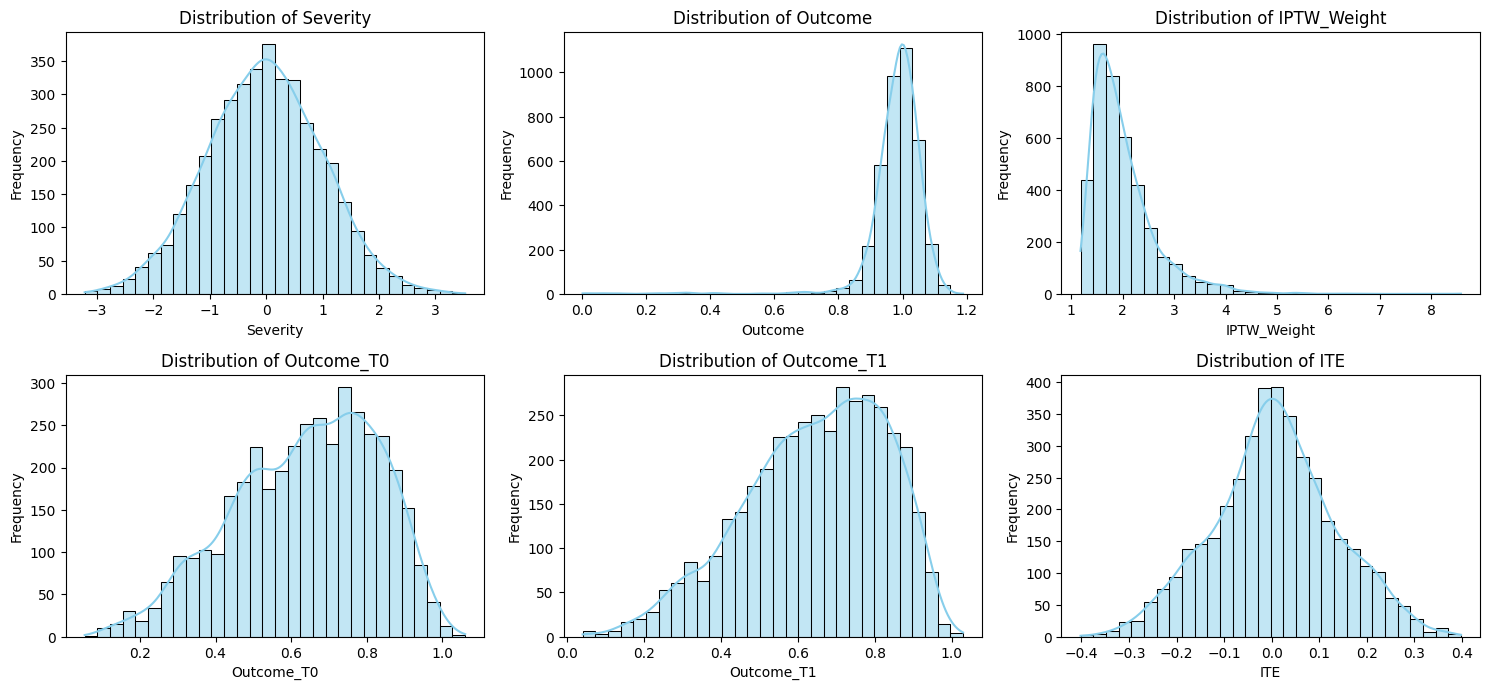

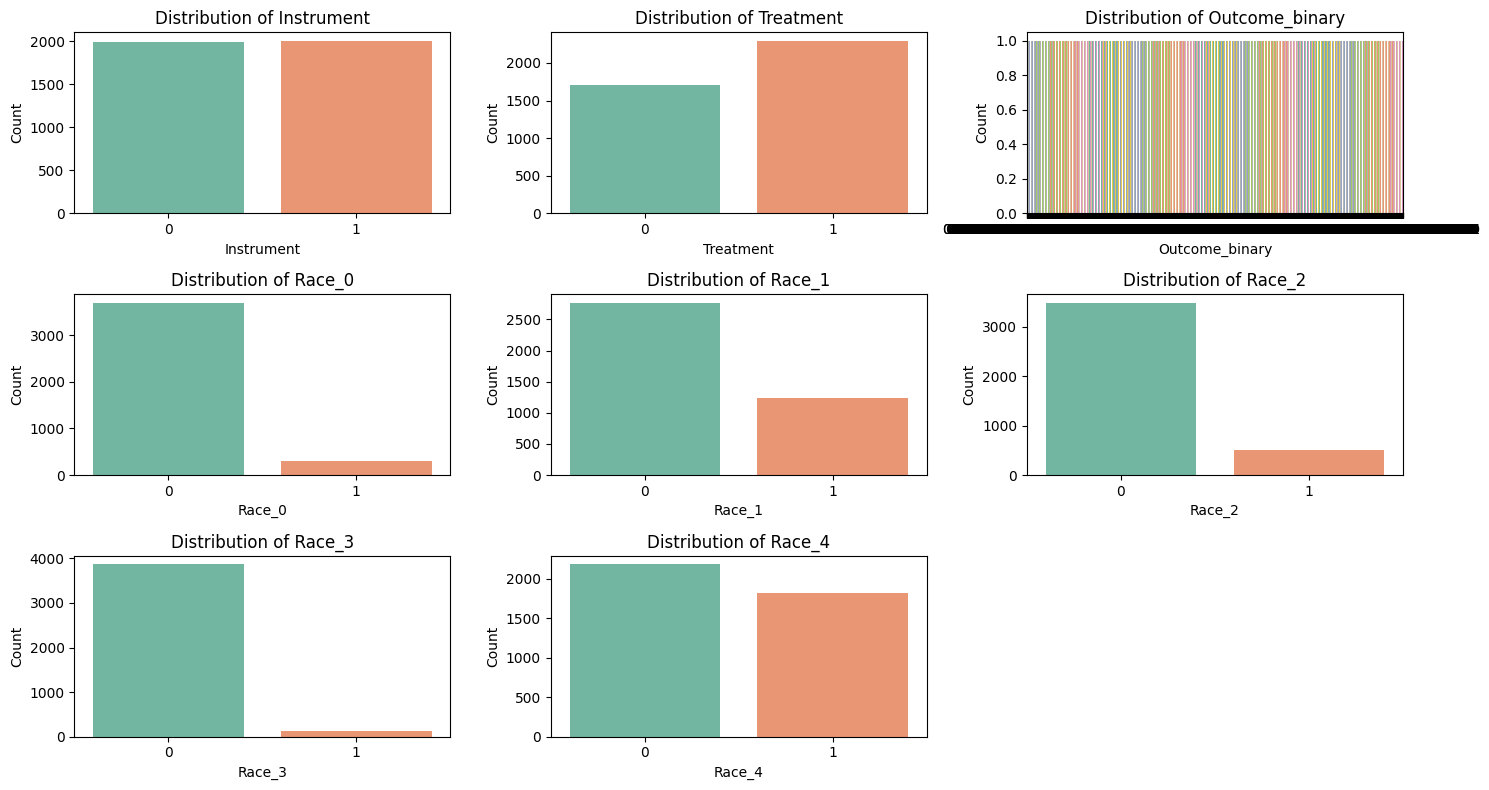

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

continuous_vars = ['Severity', 'Outcome', 'IPTW_Weight', 'Outcome_T0', 'Outcome_T1', 'ITE']
categorical_vars = ['Instrument', 'Treatment', 'Outcome_binary', 'Race_0', 'Race_1', 'Race_2', 'Race_3', 'Race_4']

plt.figure(figsize=(15, 10))
for i, var in enumerate(continuous_vars):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data[var], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
for i, var in enumerate(categorical_vars):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=var, data=data, palette='Set2') 
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

Fairness Metrics Summary Table (All Racial Groups)
          Precision     TPR     FPR  Calibration Error    CATE  \
Asian        0.6786  0.9048  0.6923             0.1436  0.2733   
Other        0.6330  0.8165  0.6501             0.0552  0.2664   
Hispanic     0.6257  0.8020  0.6745             0.0964  0.2667   
Black        0.6284  0.7662  0.5836             0.0540  0.2691   
White        0.6071  0.7169  0.5540             0.1389  0.2599   

          Outcome_Disparity  TPR_Gap(%)  
Asian               -0.0604     12.9141  
Other               -0.0539      1.9040  
Hispanic            -0.0592      0.0911  
Black               -0.0663     -4.3742  
White               -0.0574    -10.5351  


<Figure size 1200x600 with 0 Axes>

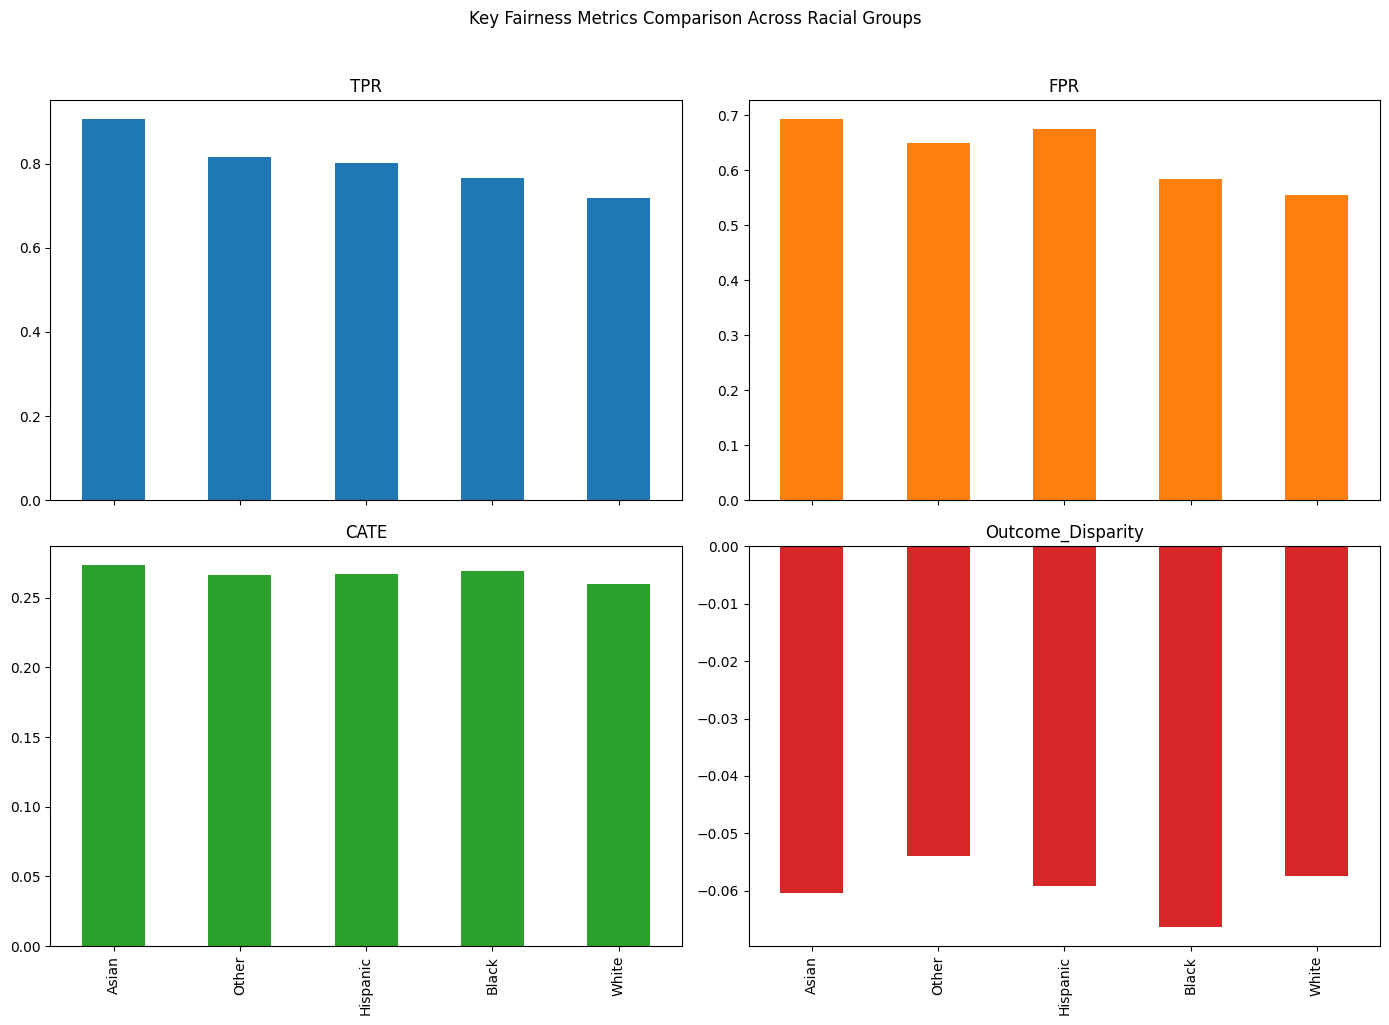

In [22]:
# summary table
def generate_fairness_summary(group_fairness_metrics, outcome_fairness_matrix, cate_series):
    fairness_df = pd.DataFrame(group_fairness_metrics).T
    fairness_df['CATE'] = cate_series
    fairness_df['Outcome_Disparity'] = np.diag(outcome_fairness_matrix) - outcome_fairness_matrix.mean(axis=1)
    fairness_df['TPR_Gap(%)'] = (fairness_df['TPR'] - fairness_df['TPR'].mean()) / fairness_df['TPR'].mean() * 100
    fairness_df['FPR_Gap(%)'] = (fairness_df['FPR'] - fairness_df['FPR'].mean()) / fairness_df['FPR'].mean() * 100
    fairness_df['CATE_Gap(%)'] = (fairness_df['CATE'] - fairness_df['CATE'].mean()) / fairness_df['CATE'].mean() * 100
    
    fairness_df = fairness_df.sort_values('TPR_Gap(%)', ascending=False)
    
    return fairness_df.round(4)

fairness_summary = generate_fairness_summary(group_fairness_metrics, 
                                           outcome_fairness_matrix,
                                           cate_series)

print("="*80)
print("Fairness Metrics Summary Table (All Racial Groups)")
print("="*80)
print(fairness_summary[['Precision', 'TPR', 'FPR', 'Calibration Error', 
                       'CATE', 'Outcome_Disparity', 'TPR_Gap(%)']])

fairness_summary.to_csv("fairness_metrics_summary.csv")

plt.figure(figsize=(12, 6))
metrics_to_plot = ['TPR', 'FPR', 'CATE', 'Outcome_Disparity']
fairness_summary[metrics_to_plot].plot(kind='bar', subplots=True, 
                                      layout=(2,2), figsize=(14, 10),
                                      sharey=False, legend=False)
plt.suptitle("Key Fairness Metrics Comparison Across Racial Groups", y=1.02)
plt.tight_layout()
plt.show()

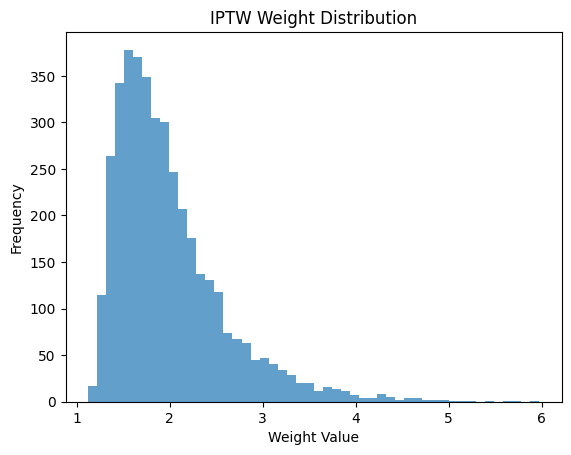

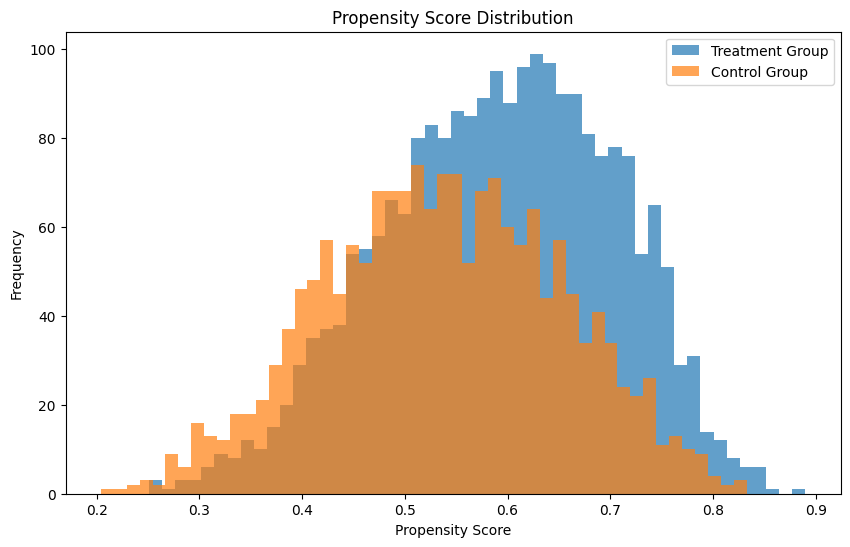

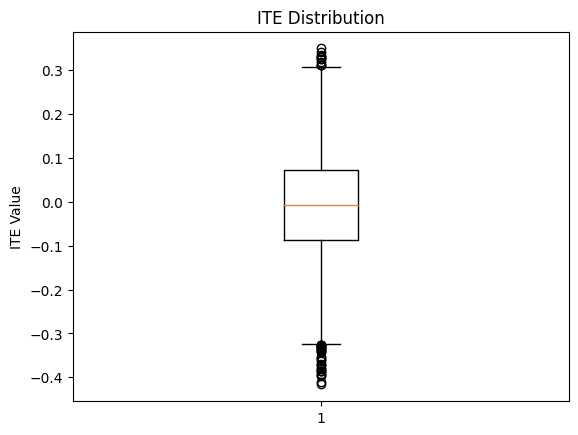

In [57]:
# Weight distribution check
plt.hist(data['IPTW_Weight'], bins=50, alpha=0.7)
plt.title("IPTW Weight Distribution")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()

# Propensity score overlap check
plt.figure(figsize=(10, 6))
plt.hist(data[data['Treatment'] == 1]['Propensity_Score'], bins=50, alpha=0.7, label="Treatment Group")
plt.hist(data[data['Treatment'] == 0]['Propensity_Score'], bins=50, alpha=0.7, label="Control Group")
plt.title("Propensity Score Distribution")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# ITE distribution check
plt.boxplot(data['ITE'])
plt.title("ITE Distribution")
plt.ylabel("ITE Value")
plt.show()